In [1]:
import fio.database
import mip

db = fio.database.load_db("data")

In [2]:
import functools

def is_fluid(name):
    return db.fluid.query(f"""map(select(.name == "{name}"))|any""")

def is_item(name):
    return db.item.query(f"""map(select(.name == "{name}"))|any""")

assert is_item("iron-ore")
assert not is_fluid("iron-ore")

assert not is_item("water")
assert is_fluid("water")

@functools.lru_cache(16)
def get_assembly_machines(category, craftable_only=True):
  ms = []

  for m in db.assembling_machine.find(f""".[] | select(.crafting_categories."{category}")"""):
    if craftable_only and not db.recipe.query(f"""map( select(.main_product.name == "{m['name']}" )) | any"""):
      continue
    ms.append(m)

  for m in db.furnace.find(f""".[] | select(.crafting_categories."{category}") """):
    if craftable_only and not db.recipe.query(f"""map( select(.main_product.name == "{m['name']}" )) | any"""):
      continue
    ms.append(m)

  return ms

# assert get_assembly_machines("nuclear-fusion") == ['kr-fusion-reactor']
# assert set(get_assembly_machines("basic-crafting")) == {'assembling-machine-1', 'assembling-machine-2', 'assembling-machine-3', 'kr-advanced-assembling-machine'}

assert len(db.recipe.find(".[] | select(.hidden) | .name")) == 750
assert len(db.assembling_machine.find(""".[] | select(.crafting_categories."basic-crafting") | .name""")) == 6
assert db.recipe.query("""map( select(.main_product.name == "laser-turret" ))|any""") == True
assert db.recipe.query("""map( select(.main_product.name == "rien" ))|any""") == False

In [3]:
recipes = fio.database.HyperDiGraph()

ignore_machines = [
    "kr-advanced-assembling-machine",
    "kr-advanced-chemical-plant",
    "kr-advanced-furnace",
    "stone-furnace",
    "steel-furnace",
    # "electric-furnace",
    "assembling-machine-3",
    "kr-matter-assembler",
    "kr-matter-plant",
    "kr-quantum-computer"
]

for r in db.recipe.find(".[]"):
    for m in get_assembly_machines(r['category']):

        if m["name"] in ignore_machines:
            continue

        A = {i["name"] for i in r["ingredients"]}
        B = {p["name"] for p in r["products"]}
        recipes.add_edge(A, B, {"recipe": r, "machine": m, "name": f"{r['name']}#{m['name']}"})


In [4]:
import fio.flow


source = {
    "iron-ore": float("+inf"),
    "crude-oil": float("+inf"),
    "copper-ore": float("+inf"),
    "stone": float("+inf"),
    "coal": float("+inf"),
    "water": float("+inf"),
    "wood": float("+inf"),
    "biomass": float("+inf"),
    "uranium-238": float("+inf"),
    "imersite-powder": float("+inf"),
    "mineral-water": float("+inf"),
    "raw-rare-metals": float("+inf"),
}

target = {
    k: 1 for k in {
        # 'basic-tech-card',
        # 'advanced-tech-card',
        'automation-science-pack',
        # 'biters-research-data',
        'chemical-science-pack',
        'logistic-science-pack',
        'production-science-pack',
        'utility-science-pack',
        # 'matter-research-data',
        # 'matter-tech-card',
        # 'military-science-pack',
        # 'singularity-tech-card',
    }
}

model = fio.flow.optimize_model(recipes, dict(**source, **{k: -v for k, v in target.items()}))

print(model["status"])
# model = build_detailed_graph(model)

OptimizationStatus.OPTIMAL


In [5]:

from collections import defaultdict, namedtuple

inputs = defaultdict(float)
outputs = defaultdict(float)
c = defaultdict(int)


flows = []
i = 0


from uuid import uuid4

Cell = namedtuple("Cell", ["id", "recipe", "machine", "intergral", "fractional"])

def unique_id(i):
  r = unique_id.c[i]
  unique_id.c[i] += 1
  return f"id_{i}_{r}"
unique_id.c = defaultdict(int)

import networkx as nx
graph = nx.DiGraph()

per_rows = 4
for r, m, k, f in [tuple(k.split("#") + list(v)) for k, v in model["flow"].items()]:
    c[m] += k

    r = db.recipe.query(f"""map( select(.name == "{r}"))""")[0]

    m1 = db.assembling_machine.query(f"""map( select(.name == "{m}")) """)
    m2 = db.furnace.query(f"""map( select(.name == "{m}")) """)
    m = (m1 + m2)[0]

    for _ in range(k-1):
      i = unique_id(r["name"])
      flows.append(Cell(i, r, m, 1, 1))
      graph.add_node(i, kind="transformator", recipe=r, machine=m, k=1, f=1)

    assert f-k+1 > 0
    i = unique_id(r["name"])
    flows.append(Cell(i, r, m, 1, f-k+1))
    graph.add_node(i, kind="transformator", recipe=r, machine=m, k=1, f=f-k+1)

c

defaultdict(int,
            {'assembling-machine-2': 151,
             'electric-furnace': 117,
             'kr-atmospheric-condenser': 6,
             'chemical-plant': 8,
             'oil-refinery': 13,
             'kr-crusher': 6,
             'kr-research-server': 8,
             'kr-filtration-plant': 5,
             'kr-fuel-refinery': 16})

# Second step.


We now need to know how many machines are needed for which exchange. To do so, we build an other linear program, with pack bins everywhere.




# Bin packing

Inputs:
* $v[j]$ output flow required
* $u[i]$ input flow required

Variables:
* $x[i, j]$ real between 0 and 1, indicate the flow from $i$ to j$
* $y[i, j]$ boolean indicate if the edge from $i$ to $j$

Minimize $\displaystyle \sum_{i, j} y[i, j]$
Subject:
* $\displaystyle \forall i j, x[i, j] \leq y[i, j]$
* $\displaystyle \forall i, \sum_j x[i, j] = u_i$
* $\displaystyle \forall j, \sum_i x[i, j] = v_j$




In [6]:
import fio.binpacking
from fractions import Fraction

items = set()

flow_in = defaultdict(list)
flow_out = defaultdict(list)
for f in flows:

  ing = {k: v*f.fractional for k, v in fio.flow.ingredients_coefs(f.recipe, f.machine).items()}
  pro = {k: v*f.fractional for k, v in fio.flow.products_coefs(f.recipe, f.machine).items()}

  for i, q in ing.items():
    q = Fraction(q).limit_denominator()
    assert q >= 0
    flow_in[i].append((f.id, q))
  for i, q in pro.items():
    q = Fraction(q).limit_denominator()
    assert q >= 0
    flow_out[i].append((f.id, q))


for i in set(flow_in.keys()) | set(flow_out.keys()):
  a = sum(q for _, q in flow_in[i])
  b = sum(q for _, q in flow_out[i])
  if a > b:
    j = unique_id("sink")
    graph.add_node(j, kind="sink")
    flow_out[i].append(((j), a - b))
  elif b > a:
    j = unique_id("source")
    graph.add_node(j, kind="source")
    flow_in[i].append(((j), b - a))


assert set(flow_in.keys()) == set(flow_out.keys())

In [19]:
import numpy as np

pos = None
for i in range(2):
  new_graph = nx.DiGraph(graph)

  for k in flow_in.keys():
    in_ = flow_in[k]
    out = flow_out[k]

    idxA, A = zip(*out)
    idxB, B = zip(*in_)

    pairs = fio.binpacking.optimize(
      [a / sum(A) for a in A],
      [b / sum(B) for b in B],
      weights=None if pos is None else {(i, j): np.sqrt(np.sum((pos[a] - pos[b])**2)) for i, a in enumerate(idxA) for j, b in enumerate(idxB)}
    )

    for (i, j), f in pairs.items():
      new_graph.add_edge(idxA[i], idxB[j], w=f/A[i]*sum(A))

  pos = nx.kamada_kawai_layout(new_graph)

# pos = nx.spring_layout(new_graph, pos=pos)

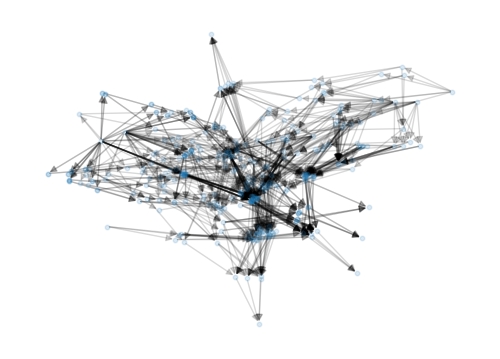

In [85]:
import random
from collections import deque

nx.draw(new_graph, pos=pos, node_size=10, alpha=.15)


In [78]:
def spiral_out_generator():
    layer = 1
    leg = 0
    x, y = 0, 0
    while True:
        yield x, y
        if leg == 0:
            x += 1
            if x == layer:
                leg += 1
        elif leg == 1:
            y += 1
            if y == layer:
                leg += 1
        elif leg == 2:
            x -= 1
            if -x == layer:
                leg += 1
        elif leg == 3:
            y -= 1
            if -y == layer:
                leg = 0
                layer += 1

def find_nearest_unoccupied_cell(i, j, occupied, k):
    spiral = spiral_out_generator()
    while True:
        ni, nj = next(spiral)
        ni, nj = i + ni, j + nj
        if 0 <= ni < k and 0 <= nj < k and (ni, nj) not in occupied:
            return ni, nj



In [230]:
k = int(np.ceil(np.sqrt(len(new_graph.nodes))))



pos_int = {}

pos_a = np.array(list(pos.values()))
min_x, min_y = np.quantile(pos_a, 0.2, axis=0)
max_x, max_y = np.quantile(pos_a, 0.8, axis=0)

occupied = set()
l = list(pos.items())
random.shuffle(l)
for key, (x, y) in l:
    i = int((x-min_x)/(min_x-max_x) * k)
    j = int((y-min_y)/(min_y-max_y) * k)
    i, j = find_nearest_unoccupied_cell(i, j, occupied, k)
    occupied.add((i, j))
    pos_int[key] = np.array((i, j))


pos_random = dict()

available = [(i, j) for i in range(k) for j in range(k)]
random.shuffle(available)
for key, x in zip(pos.keys(), available):
    pos_random[key] = np.array(x)

print(sum(w * np.sqrt(np.sum((pos_int[u] - pos_int[v])**2)) for u, v, w in new_graph.edges(data="w")))

print(sum(w * np.sqrt(np.sum((pos_random[u] - pos_random[v])**2)) for u, v, w in new_graph.edges(data="w")))


3077.2827531511457
3704.7568267039856


The current position seems to be good enought for actual blueprint construction using robots

# Blueprint construction

We don't need for each recipes to create a new blueprint: we only need one blueprint for each machines and fluids inputs and outputs.


In [231]:
import pandas as pd

df = {}

def select(kind1, kind2):
  return sum(1 for i in data["recipe"][kind1] if i["type"] == kind2)

for node, data in new_graph.nodes(data=True):
  if data["kind"] != "transformator":
    continue
  df[node] = {
    "machine": data["machine"]["name"],
    "recipe": data["recipe"]["name"],
    "item_in": select("ingredients", "item"),
    "item_out": select("products", "item"),
    "fluid_in": select("ingredients", "fluid"),
    "fluid_out": select("products", "fluid"),
    "data": data,
  }

df = pd.DataFrame(df).T

df.groupby(["machine", "item_in", "item_out", "fluid_in", "fluid_out"]).count()


recipe  data
machine                  item_in item_out fluid_in fluid_out              
assembling-machine-2     1       1        0        0              21    21
                         2       1        0        0              33    33
                                          1        0               8     8
                         3       1        0        0              83    83
                                          1        0               6     6
chemical-plant           0       1        2        0               1     1
                         1       1        1        0               6     6
                         2       0        1        1               1     1
electric-furnace         1       1        0        0             111   111
                         2       1        0        0               6     6
kr-atmospheric-condenser 0       0        0        1               6     6
kr-crusher               1       1        0        0               6     6
kr-filtration-plant      1       1        1        0               5     5
kr-fuel-refinery         1       1        2        0              16    16
kr-research-server       4       1        0        0               8     8
oil-refinery             0       0        2        3              13    13

In [ ]:
item1
item1amount
item2
item2amount
item3
item3amount

product1
product1amount

fluid1
fluid1amount



In [233]:
import fio.blueprint

with open("blueprints/automated1.json.base64") as f:
  book = fio.blueprint.loads(f.read())


book = {b["blueprint"]["label"]: b["blueprint"] for b in book["blueprint_book"]["blueprints"]}

book["f-n-n"]

{'icons': [{'signal': {'type': 'item', 'name': 'electric-furnace'},
   'index': 1}],
 'entities': [{'entity_number': 1,
   'name': 'electric-furnace',
   'position': {'x': -106.5, 'y': -39.5}},
  {'entity_number': 2,
   'name': 'logistic-chest-passive-provider',
   'position': {'x': -107.5, 'y': -36.5}},
  {'entity_number': 3,
   'name': 'fast-inserter',
   'position': {'x': -107.5, 'y': -37.5}},
  {'entity_number': 4,
   'name': 'logistic-chest-requester',
   'position': {'x': -106.5, 'y': -36.5}},
  {'entity_number': 5,
   'name': 'fast-inserter',
   'position': {'x': -106.5, 'y': -37.5},
   'direction': 4},
  {'entity_number': 6,
   'name': 'medium-electric-pole',
   'position': {'x': -105.5, 'y': -36.5}}],
 'item': 'blueprint',
 'label': 'f-n-n',
 'version': 281479276527617}

In [232]:
barrels_recipes = {k for k in db.recipe.keys() if "barrel" in k}

{k: (f"empty-{k}-barrel" in barrels_recipes and f"fill-{k}-barrel" in barrels_recipes) for k in db.fluid.keys()}

{'fluid-unknown': False,
 'water': True,
 'crude-oil': True,
 'steam': False,
 'heavy-oil': True,
 'light-oil': True,
 'petroleum-gas': True,
 'sulfuric-acid': True,
 'lubricant': True,
 'hydrogen': True,
 'mineral-water': True,
 'chlorine': True,
 'dirty-water': True,
 'oxygen': True,
 'nitrogen': True,
 'ammonia': True,
 'nitric-acid': True,
 'hydrogen-chloride': True,
 'biomethanol': True,
 'heavy-water': True,
 'matter': False}

In [ ]:
fio.blueprint.loads("""0eNqVk9lug0AMRf/Fz0xUCEvLr1RRxOKA1VnozBAVRfx7DWlQ0hKhPiA8yHPuxcsFStljZ0l7yC9AldEO8vcLOGp0IadvfugQciCPCgLQhZpOH1YUXhnXtWipEnytRu3QwhgAcfwFeTgeAkDtyRNemfNhOOpelZyZh9u0ADrjGGD05IShIgzfdkkAA4dxsktYriaL1TUlDoBjmv22Q21Ng5od/VGOFuXCOVSlJN0IVVQtaRTRqmqyqKa/VdM71RNJKW7SoiysRbnmYL84UFhTrwRKxk0/3xmJqw7SxUHMDlaY8cI8Fc4LmironxQxfoA9FnEFnfwDnWz5TBeYNA05P3W8RcZ23A06o+isOVO9id+v47NneIufPb83K7KfK/KTfeSO8pXrAN8me1FA1fnh1uYAKtNPexS+jIdp+OeVye82LIAzo2bZ6DWMs7coSxN+wmwcvwHvxCnW""")